In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# import utilities and plotting
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import os, sys 
sys.path.append(os.path.abspath("lib")) # N.B: NB needs this line to run locally!!

# make figures higher resolution (larger)
plt.rcParams['figure.dpi'] = 80
# A decent backend for animations
plt.rcParams["animation.html"] = "jshtml"
# let 'em get big
plt.rcParams["animation.embed_limit"] = 80  # MB

# import our code that we need
import fixed_center_of_mass_exact as fcm
#import fixed_center_of_mass_exact as fsm
from davidson import solve_davidson
from constants import *
from hamiltonian import solve_BO_surfaces
from plotting import plotpotential2D

# don't use too many cores
from threadpoolctl import ThreadpoolController
threadctl = ThreadpoolController()
threadctl.limit(limits=16)

In [5]:
# set up the calculation
args1 = Namespace(
    M_1 = 40, M_2 = 40, J=0,
    g_1 = 1.0, g_2 = 1.0,
    NR = 51, Nr =32 , Ng = 34,
    #NR = 25, Nr = 200, Ng = 100,
    extent = (0.2,3,3),   # defaults are (2,4,5), but they should be selected better (R_min, R_max, r_max)
    t = 16
)

# build the terms in the Hamiltonian
H1 = fcm.Hamiltonian(args1)

args100 = Namespace(
    M_1 = 4000, M_2 = 4000, J=0,
    g_1 = 1.0, g_2 = 1.0,
    NR = 51, Nr =32 , Ng = 34,
    #NR = 25, Nr = 200, Ng = 100,
    extent = (0.2,3,3),   # defaults are (2,4,5), but they should be selected better (R_min, R_max, r_max)
    t = 16
)

# build the terms in the Hamiltonian
H100 = fcm.Hamiltonian(args100)

# levels = np.linspace(np.min(H.Vgrid), np.min(H.Vgrid) + 0.15, 16) # 0.15 a.u. ~4 eV range
# print(levels)
# display(plotpotential2D(H, levels))

[Build preconditioner naive] Elapsed time: 6.76us
[Build preconditioner naive] Elapsed time: 3.61us


In [10]:
# build KE in the "scaled" frame
KE1 = 1/(H1.mu)*H1.ddr2
KE100 = 1/(H100.mu)*H100.ddr2

mu_r1 =H1.mu**2/H1.mu12
mu_r100 = H100.mu**2/H100.mu12

# build KE in the "lab frame"
KEt = 1/mu_r100*H100.ddr_lab2
# print(KE1[:3,:3])
# print(KEt[:3,:3])
print("NOT FIXED YET!!!!!")
print("ratio lab KE / scaled KE :",(KEt/KE100)[0,0])


print("check: two ways to build mu_r!!", H1.mu**2/H1.mu12, H1.mu*H1.aa**2)

mu_check = H1.m_e*(H1.M_1 + H1.M_2) / (H1.m_e + H1.M_1 + H1.M_2)
print("mu_r check, 2/3 < mu_r < 1 by definition!!! ", mu_check)

print(mu_r100/mu_r1, H100.mu/H1.mu)
# print(H1.aa,H1.r[-1]*H1.aa)
# print(H100.aa,H100.r[-1]*H100.aa)
# print(H100.mu*H1.aa**2/(H1.mu*H100.aa**2))

NOT FIXED YET!!!!!
ratio lab KE / scaled KE : 2000.2500000000005
check: two ways to build mu_r!! 0.9876543209876545 0.9876543209876543
mu_r check, 2/3 < mu_r < 1 by definition!!!  0.9876543209876543
1.012373453318335 10.061677063583064


Building BO spectrum
Mock call to tqdm({'total': 51, 'desc': 'Building electronic surfaces'})
Mock call to tqdm({'total': 1088, 'desc': 'Building vibrational states'})
Building BO spectrum
Mock call to tqdm({'total': 51, 'desc': 'Building electronic surfaces'})
Mock call to tqdm({'total': 1088, 'desc': 'Building vibrational states'})


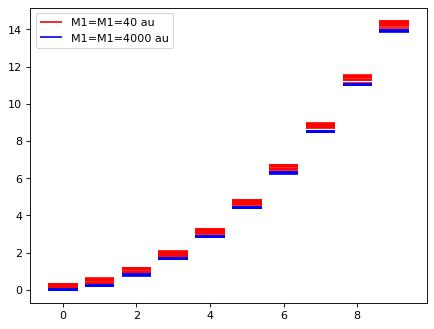

In [11]:
#B = np.load('../spec.npz')['bo_spectrum']*HARTREE_TO_EV
BO, BO_surf = H1.BO_spectrum()
B100, B100_surf = H100.BO_spectrum()
# plt.plot(np.arange(10), np.arange(10)**2)

### N.B: note we had the transpose plotted by mistake BO[:10,n] --> BO[n,:10]
plt.hlines(BO[0,:10] - BO[0,0], (0-0.4), (0+0.4), "r", label="M1=M1=40 au")
plt.hlines(B100[0,:10] - B100[0,0], (0-0.4), (0+0.4), "b", label="M1=M1=4000 au")
for n in range(1,10):
    plt.hlines(BO[n,:10] - BO[0,0], (n-0.4), (n+0.4), "r")
    plt.hlines(B100[n,:10] - B100[0,0], (n-0.4), (n+0.4), "b")
plt.legend(loc='upper left')
    # plt.hlines(BO[:10,n] - BO[0,0], (n-0.4), (n+0.4), "r")
    # plt.hlines(B100[:10,n] - B100[0,0], (n-0.4), (n+0.4), "b")
    #plt.hlines(BOorig[:10,n] - BOorig[0,0], (n-0.4), (n+0.4), 'k')

### makes complete sense that it looks ~ n^2, the BO states of H_2+ \propto n^2, check intro quantum book


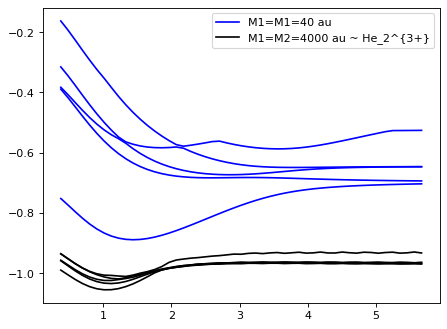

In [12]:
plt.plot(H1.R_lab, BO_surf[:,0], 'b',label="M1=M1=40 au")
plt.plot(H100.R_lab, B100_surf[:,0], 'k', label="M1=M2=4000 au ~ He_2^{3+}")
for i in range(1,5):
    plt.plot(H1.R_lab, BO_surf[:,i], 'b')
    plt.plot(H100.R_lab, B100_surf[:,i],'k')
plt.legend()
# plt.ylim(top=0.01)